Il s’agira cette fois de réaliser les implémentations de manière parallélisé.
Pour rappel, le multi-threading n’existe pas vraiment en Python à cause du GIL (possibilité de suppression dans les prochaines versions).

In [1]:
import threading
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import queue
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import asyncio
import networkx as nx

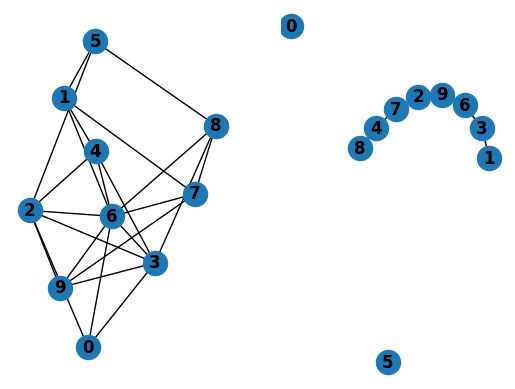

In [2]:
G1 = nx.gnp_random_graph(10, 0.5, directed=False)
G2 = nx.gnp_random_graph(10, 0.15, directed=False)

plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.show()

In [3]:
""" Implement the same function as this:
def est_clique(G, S):
    for v in S:
        for w in S:
            if v != w and not G.has_edge(v, w):
                return False
    return True

def recherche_clique(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    for i in range(2**n):
        S = set()
        for j in range(n):
            if (i >> j) & 1:
                S.add(j)
        if len(S) > taille_max_clique and est_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
    return clique_max

But using a parallel algorithm.
"""

def est_clique(G, S):
    for v in S:
        for w in S:
            if v != w and not G.has_edge(v, w):
                return False
    return True

def recherche_clique_prl(G, i, n, result, lock):
    taille_max_clique = 0
    clique_max = set()
    S = set()
    for j in range(n):
        if (i >> j) & 1:
            S.add(j)
    if len(S) > taille_max_clique and est_clique(G, S):
        with lock:
            result.append((len(S), S))

def r_prl(G):
    n = G.number_of_nodes()
    result = []
    lock = threading.Lock()

    threads = []
    for i in range(2**n):
        thread = threading.Thread(target=recherche_clique_prl, args=(G, i, n, result, lock))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    taille_max_clique, clique_max = max(result)
    print("Maximum Clique:", clique_max)

r_prl(G1)

Maximum Clique: {0, 2, 3, 6}


In [5]:
# Benchmark
def recherche_clique(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    for i in range(2**n):
        S = set()
        for j in range(n):
            if (i >> j) & 1:
                S.add(j)
        if len(S) > taille_max_clique and est_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
    return clique_max

# benchmark between recherche_clique and r_prl
G = nx.gnp_random_graph(10, 0.5, directed=False)
print("Benchmarking...")
start = time.time()
recherche_clique(G)
end = time.time()
print("recherche_clique:", end - start)

start = time.time()
r_prl(G)
end = time.time()
print("r_prl (threading):", end - start)


Benchmarking...
recherche_clique: 0.0027577877044677734
Maximum Clique: {1, 2, 6, 9}
r_prl (threading): 0.05633854866027832
